# Annual TS and SST correlation - SEB/SMB

In [1]:
%pylab inline
import os
import downglacier.sandbox.tcd_utils as utils
import downglacier.graphics as dgplot
import seaborn as sns
import pandas as pd
from datetime import datetime as dt
pal = sns.color_palette('pastel')
sns.set_style("ticks")
sns.set_context("talk", font_scale=1.2)

Populating the interactive namespace from numpy and matplotlib


In [2]:
lag = 3

In [3]:
wd = utils.run_standard_allz(run=False)
odir = os.path.join(wd, 'output')

## Make a predict_ts for the  whole glacier

In [4]:
dfp = pd.read_csv(os.path.join(odir, 'diagnostics', 'predict_ts.csv'), index_col=0, parse_dates= {"time" : [0]}).loc[dt(1979,10,1):dt(2013,9,1)]
dfv = pd.read_csv(os.path.join(odir, 'diagnostics', 'outercv_ts.csv'), index_col=0)
dfref = pd.read_csv(os.path.join(odir, 'diagnostics', 'ref_ts.csv'), index_col=0)
dfi = pd.read_csv(os.path.join(odir, 'diagnostics', 'predict_info.csv'), index_col=0).T

In [5]:
import netCDF4
nc = netCDF4.Dataset(os.path.join(wd, 'standard_run_predictands_shallap.nc'))
area = nc.variables['A_sc'][:]
area = area / np.sum(area)

In [6]:
odf = pd.DataFrame()
odfv = pd.DataFrame()
odfref = pd.DataFrame()
for vn in set([t.split('_')[0] for t in dfp.columns]):
    cols = [t for t in dfp.columns if (vn + '_') in t]
    if len(cols) != len(area): 
        if vn == 'submass':
            cols = [t for t in cols if ('diag') in t]
            if len(cols) != len(area): 
                print('wtf')
        else:
            continue
    typ = cols[0].split('_')[-1]
    odf[vn + '_' + typ] = (dfp[cols] * area).T.sum()
    odfv[vn + '_' + typ] = (dfv[cols] * area).T.sum()
    odfref[vn + '_' + typ] = (dfref[cols] * area).T.sum()
assert np.sum(np.abs(odf['mbtotfromsum_diag'] - dfp['mbspecfromsum_0_diag'])) < 0.01

In [7]:
errdf = ((odfv - odfref)**2).mean().apply(np.sqrt)
assert np.abs(errdf['mbtotfromsum_diag'] - dfi['mbspecfromsum_0_diag']['rmse']) < 0.01

In [8]:
# Conventions for the plots below
odf.loc[:, 'meltmassfromsum_diag'] = -odf['meltmassfromsum_diag']
odf.loc[:, 'submass_diag'] = -odf['submass_diag']

### SST lag3!

In [9]:
dfsst = utils.get_enso_df(lag=lag)
odf['yi'] = dfsst['yi']
odf['sst'] = dfsst['sst']

### Composites

In [10]:
ydf = odf.groupby('yi').mean()
tdf = pd.DataFrame(odf.mean()).T.set_index(pd.Series('val'))

### Correlations

In [11]:
for vn in tdf.columns:
    if vn in ['yi', 'sst']:
        continue
    err = errdf[vn]
    tdf.loc['err', vn] = errdf[vn]
    tdf.loc['err_avg', vn] = errdf[vn] / np.sqrt(len(ydf[vn]))
    erryr = err / np.sqrt(12)
    tdf.loc['err_yr', vn] = erryr
    tdf.loc['cor', vn] = np.corrcoef(ydf[vn], ydf['sst'])[0,1]
    
    nb = 1000 # number or realizations
    r2s = np.zeros(nb)
    data = ydf[vn]
    for i in np.arange(nb):
        r2s[i] = np.corrcoef(ydf['sst'], data + erryr * np.random.randn(len(data)))[0,1]
    tdf.loc['cor_boot', vn] = np.mean(r2s)
    tdf.loc['cor_boot_sig', vn] = np.std(r2s)

### Budget

In [12]:
name = ['$SW_{Net}$', '$LW_{Net}$', '$Q_{L}$', '$Q_{S}$', '$Q_{PS}$', '$Q_{C}$']
keys = ['swnetsum_diag','lwnetsum_diag','ql_ds','qs_ds','qps_ds','qc_ds']
dfe = tdf[keys]
dfe.columns = name
name = ['$M_{Melt}$', '$M_{Subli}$', '$M_{Subs}$', '$PRPC_{S}$']
keys = ['meltmassfromsum_diag','submass_diag','subsurfmass_ds','prcpsolclip_diag']
dfm = tdf[keys]
dfm.columns = name

In [13]:
tdf['prcptotclip_diag']

val             116.959586
err              38.991326
err_avg           6.686957
err_yr           11.255826
cor              -0.625084
cor_boot         -0.552925
cor_boot_sig      0.067555
Name: prcptotclip_diag, dtype: float64

In [14]:
def scatter_bar(ax, df, pal, fac=1.):
    for i, c in enumerate(df.columns):
        xval = df[c]['val'] * fac
        yval = df[c]['cor_boot']
        sig = df[c]['cor_boot_sig']
        err = df[c]['err']  * fac
        ax.plot([xval, xval], [yval-sig, yval+sig], '-', color=pal[i])
        ax.plot([xval-err, xval+err], [yval, yval], '-', color=pal[i])
        ax.scatter(xval, yval, s=100, marker='o', label=c,  edgecolors='k', facecolors=pal[i], zorder=99)
    
    plt.legend(frameon=True, loc='best');
    plt.grid()
    mm = np.max(np.abs(ax.get_ylim()))
    ax.set_ylim([-mm, mm]);
    mm = np.max(np.abs(ax.get_xlim()))
    ax.set_xlim([-mm, mm]);

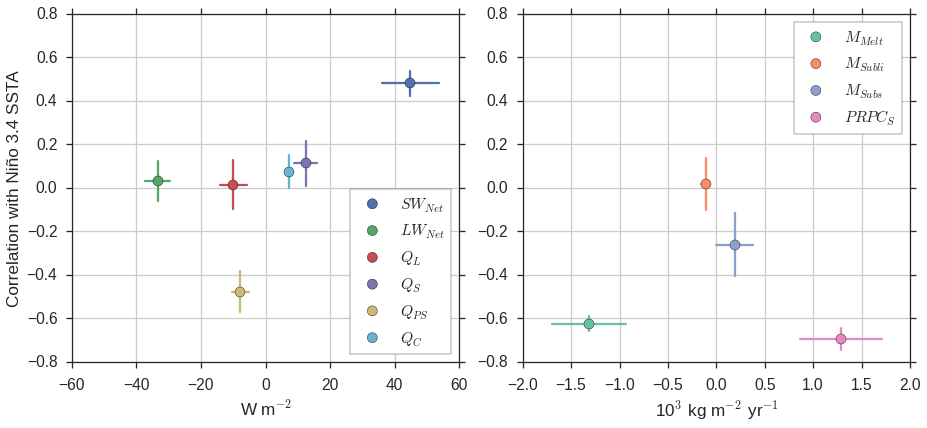

In [15]:
fig = plt.figure(figsize=(13, 6), dpi=200)
ax = fig.add_subplot(121)
scatter_bar(ax, dfe, sns.color_palette('deep'))
plt.legend(frameon=True, loc='lower right');
ax.set_xlabel('W m$^{-2}$')
ax.set_ylabel('Correlation with Niño 3.4 SSTA')
ax = fig.add_subplot(122)
scatter_bar(ax, dfm, sns.color_palette("Set2"), fac=12./1000.)
ax.set_xlabel('10$^{3}$ kg m$^{-2}$ yr$^{-1}$')
plt.tight_layout()
plt.savefig(os.path.join(utils.get_plot_dir(), 'Fig_13.pdf'))